In [15]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

import json

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# importing my model functions for analysis
from psi_transmission.model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analysis of the Degradation of the UCN Source Performance

In this notebook, various approaches to analyzing the UCN source's performance are demonstrated. The UCN source degraded over the course of the experiment, and a preliminary analysis of this performance was presented by Edgard Pierre. Below is a slide from his presentation:

![title](../misc/edgard_source_fit.png)

## Method 1: Fitting to Direct Shot Normalization Measurements

Below is a list of all the direct shot measurements performed using the normalization configuration:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
      76                     | 8   |   direct            | normalization          |
      120                    | 9   |   direct            | normalization          |
      175                    | 9   |   direct            | normalization          |
      122                    | 10  |   direct            | normalization          |
      170                    | 10  |   direct            | normalization          |
      249                    | 10  |   direct            | normalization          |
      
     

Fit parameters:
 N_0 = 6445520.6932930155 +/- 466338.6758883196,
 A: -810.4060174610078 +/- 115.79847341190049


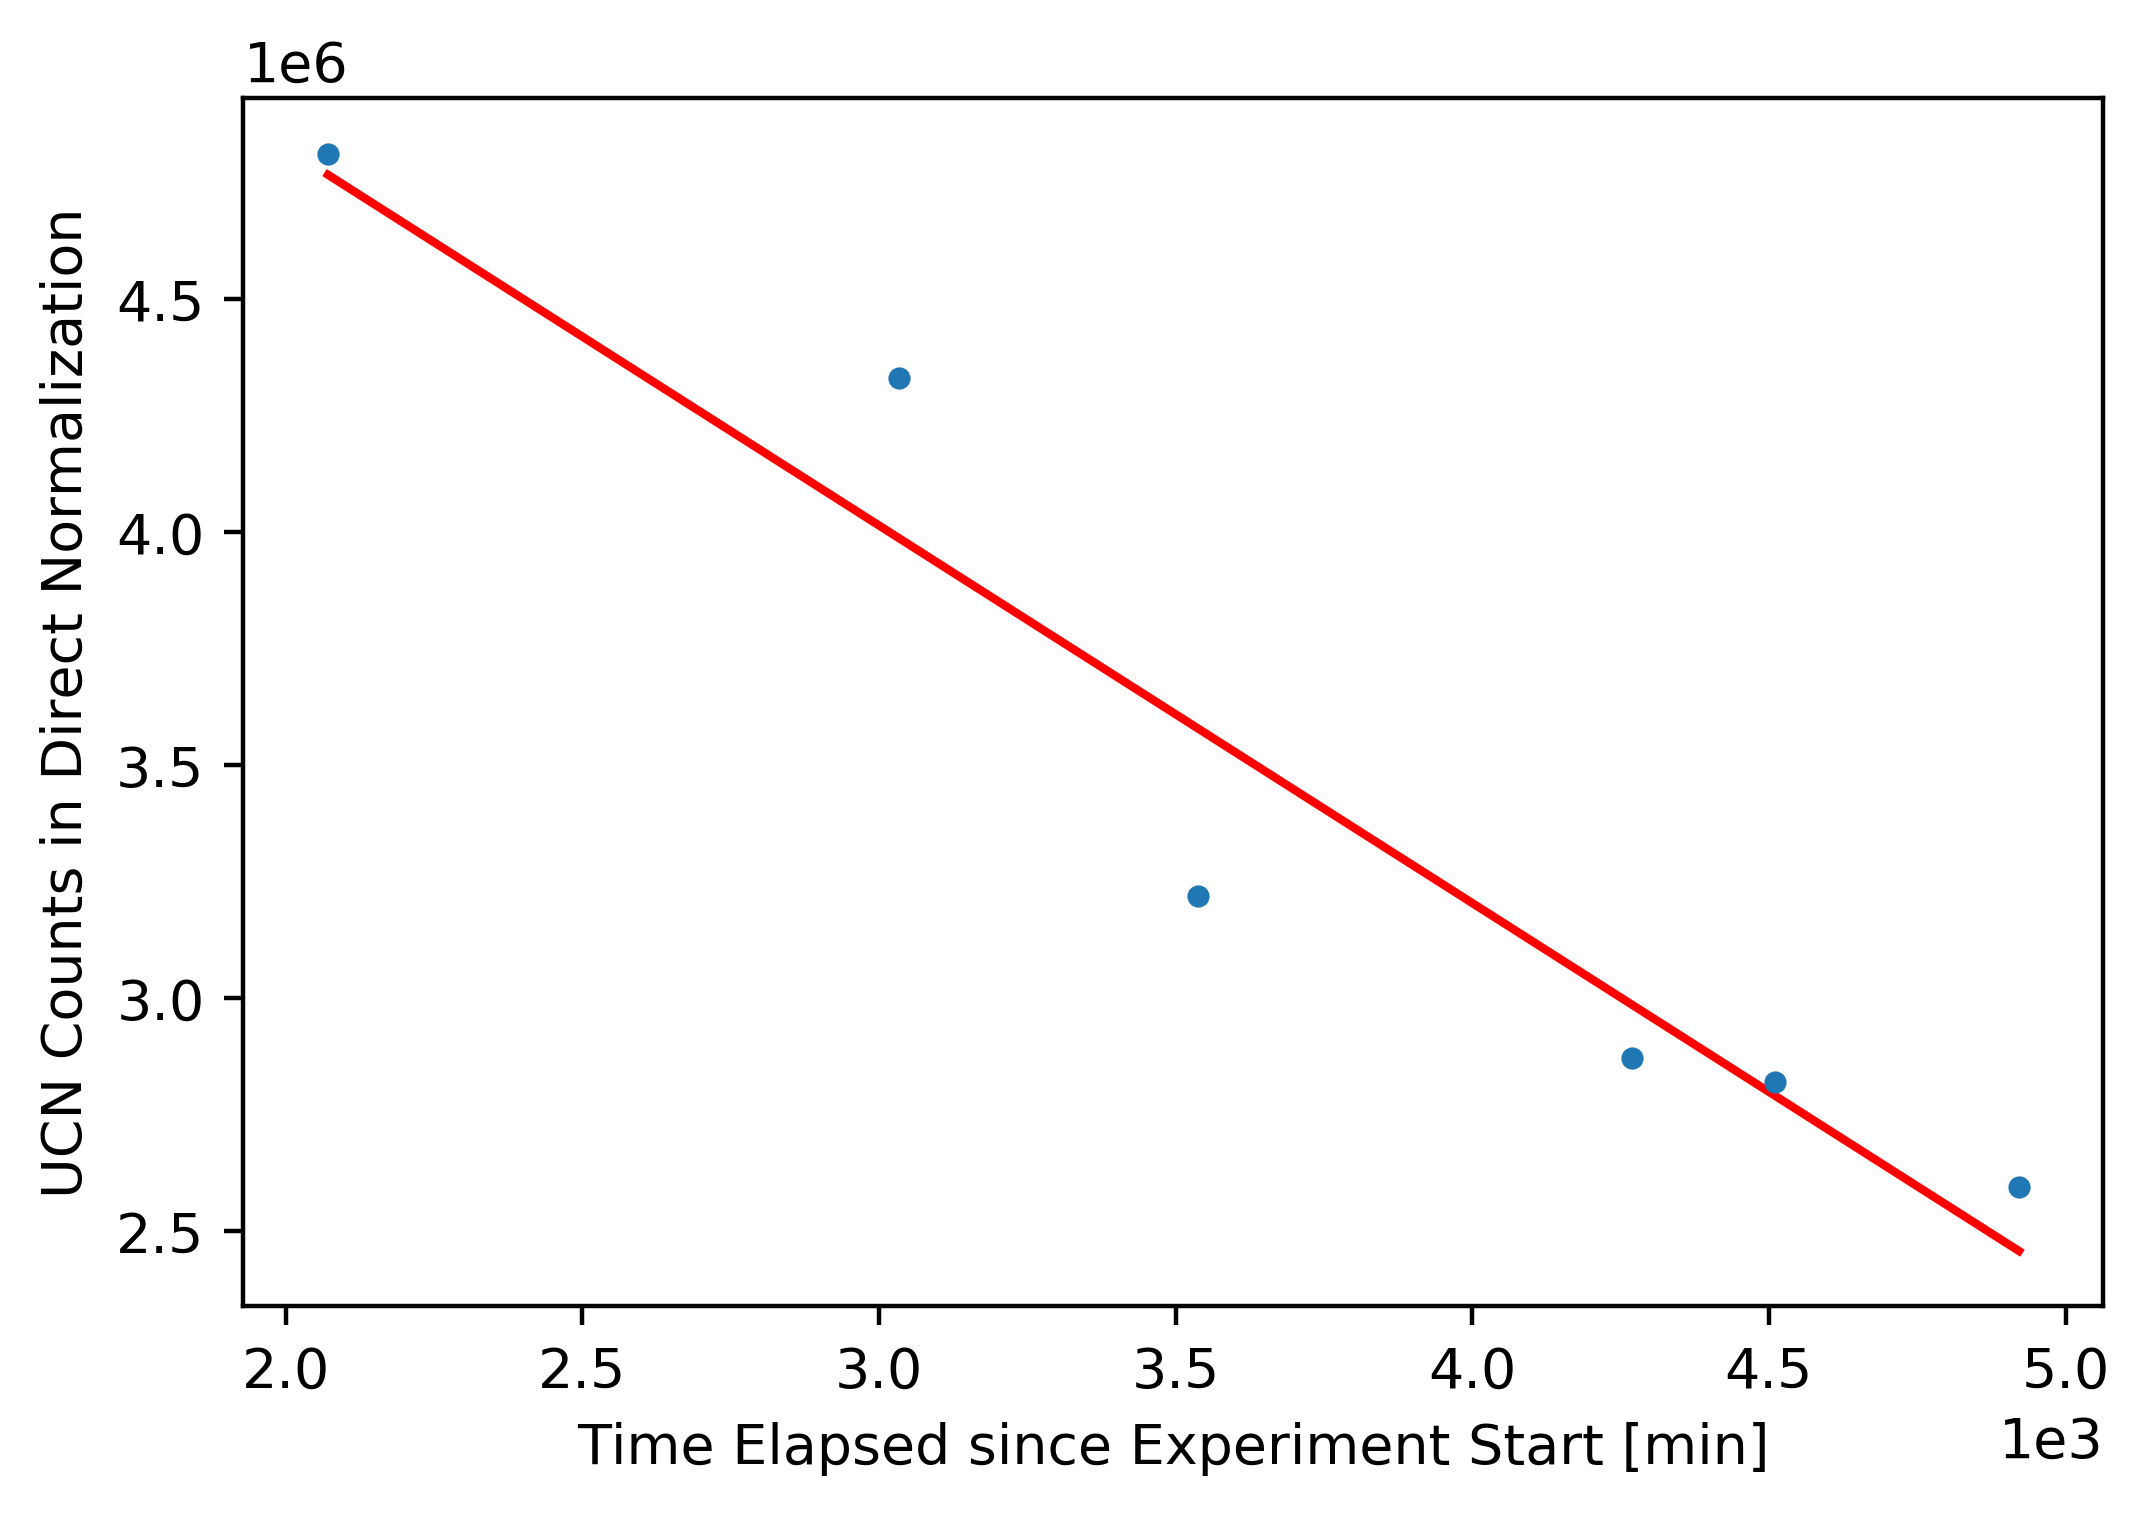

In [16]:
# load the direct shot normalization measurements into a single array
time_bins, times, data, monitor_data = load_data(
    [76, 120, 175, 122, 170, 249], 
    [ 8,   9,   9,  10,  10,  10])

def direct_normalized_source_fit(times, data):
    """Performs a fit of the UCN source performance using data from
        only the direct shot normalization runs.
    
    Args:
        times (numpy.float64): vector of run times for each run
        data (numpy.float64): Array of UCN counts 
    
    Returns:
        numpy.float64: Array of results. For every run, the summed counts and 
        associated error are returned.
    """
    
    # initialize an array to hold the result
    # two columns: 
    # - summed counts from the array
    # - error on that sum
    result = np.zeros((np.shape(data)[1], 2))
    
    # loop over the provided array
    for i in range(0, np.shape(data)[1]):
        
        # sum the counts
        sum_counts = np.sum(data[:,i])
        
        # save the summed counts and error to the result array
        result[i,0] = sum_counts
        result[i,1] = np.sqrt(sum_counts)

    return result
result = direct_normalized_source_fit(times, data)

# converting times to minutes
times = times / 60

# Some plotting
plt.errorbar(times, result[:,0], yerr = result[:,1], fmt = '.')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Time Elapsed since Experiment Start [min]')
plt.ylabel('UCN Counts in Direct Normalization');

# perform a linear fit
popt, pcov = curve_fit(source_fit, times[:,0], result[:,0], p0=[77600, -9], sigma = result[:,1])
plt.plot(times, source_fit(times, *popt), 'r-');

# printing the fit parameters and their errors:
fit_parameters = np.zeros(np.shape(pcov))
for i in range(0, np.size(popt)):
    fit_parameters[i,0] = popt[i]
    fit_parameters[i,1] = np.sqrt(np.diag(pcov))[i]
print("Fit parameters:\n N_0 = {} +/- {},\n A: {} +/- {}".format(
        fit_parameters[0,0],
        fit_parameters[0,1],
        fit_parameters[1,0],
        fit_parameters[1,1]))

Uncertainties are plotted here, but are simply $\sqrt{N}$, where $N$ is the number of counts in the run. Thus they are not large enough to be visible. This method returns a degradation of $-810.4$ UCN per minute, which is way off from Edgard's fit.

## Method 2: Fitting to the Data from Every Monitor Run

Every single run has data from both a main detector and a monitor detector. The monitor detector is connected to the source volume directly. Fitting every single run's monitor detector counts should give a high-statistics count rate over time, for use in source performance analysis.

Bernhard Lauss' description of the monitor detector's position:

>there you see, that there are 2 beamports in area West called West-1 and West-2 <br/>
which drain UCN from the bottom (W1) and top (W2) of the UCN source storage vessel.<br/>
on West-2 (which is in rate about a factor 10 less than West-1)<br/><br/>
we mounted a small cascade detector - small means 10cm x 10cm active area with 8x 8 sensitive 'pixels'<br/>
this setup stayed always the same and rate changes are due to changes is UCN source intensitites.<br/>

Given Bernhard's description, I would assume this will provide the best method of determining degradation that is isolated to source performance effects. Here is a schematic image of the source at PSI:

![title](../misc/psi_source.png)

In [17]:
# there are 1837 files in the data_monitor/12/ directory, 5 of which are neither experimental run .tof nor .txt files
# This leaves 1832 files, and thus 916 relevant .tof files.

# !!! There's an issue here because the monitor_data files and the regular data files are not all the same
# does this mean that the monitor data files have not been pruned for beam instability, and the other corrections that
# Edgard describes in his slides? We might see this in the plot of all the data. We might consider analyzing only monitor 
# data for which a proper run exists?

# Here, I first take the "all the monitor data runs available" approach:

# initializing some empty arrays to hold the run and day lists
run_list = []
day_list = []

# This returns run and day lists of every monitor run
for filename in os.listdir('../data_monitor/12'):
    if (".tof" in filename):
        run_list.append(filename[8:12].lstrip('0'))
        day_list.append(filename[1:3].lstrip('0'))
        
time_bins, times_all_monitor, data, monitor_data = load_data(
    run_list,
    day_list,
    just_monitor_flag = True)

def every_monitor_source_fit(times, data):
    """Performs a fit of the UCN source performance using every run's
        monitor_detector data
    
    Args:
        times (numpy.float64): vector of run times for each run
        data (numpy.float64): Array of UCN counts 
    
    Returns:
        numpy.float64: Array of results. For every run, the summed counts and 
        associated error are returned.
    """
    
    # initialize an array to hold the result
    # two columns: 
    # - summed counts from the array
    # - error on that sum
    result = np.zeros((np.shape(data)[1], 2))
    
    # loop over the provided array
    for i in range(0, np.shape(data)[1]):
        
        # sum the counts
        sum_counts = np.sum(data[:,i])
        
        # save the summed counts and error to the result array
        result[i,0] = sum_counts
        result[i,1] = np.sqrt(sum_counts)

    return result

result_all_monitor = direct_normalized_source_fit(times_all_monitor, monitor_data)

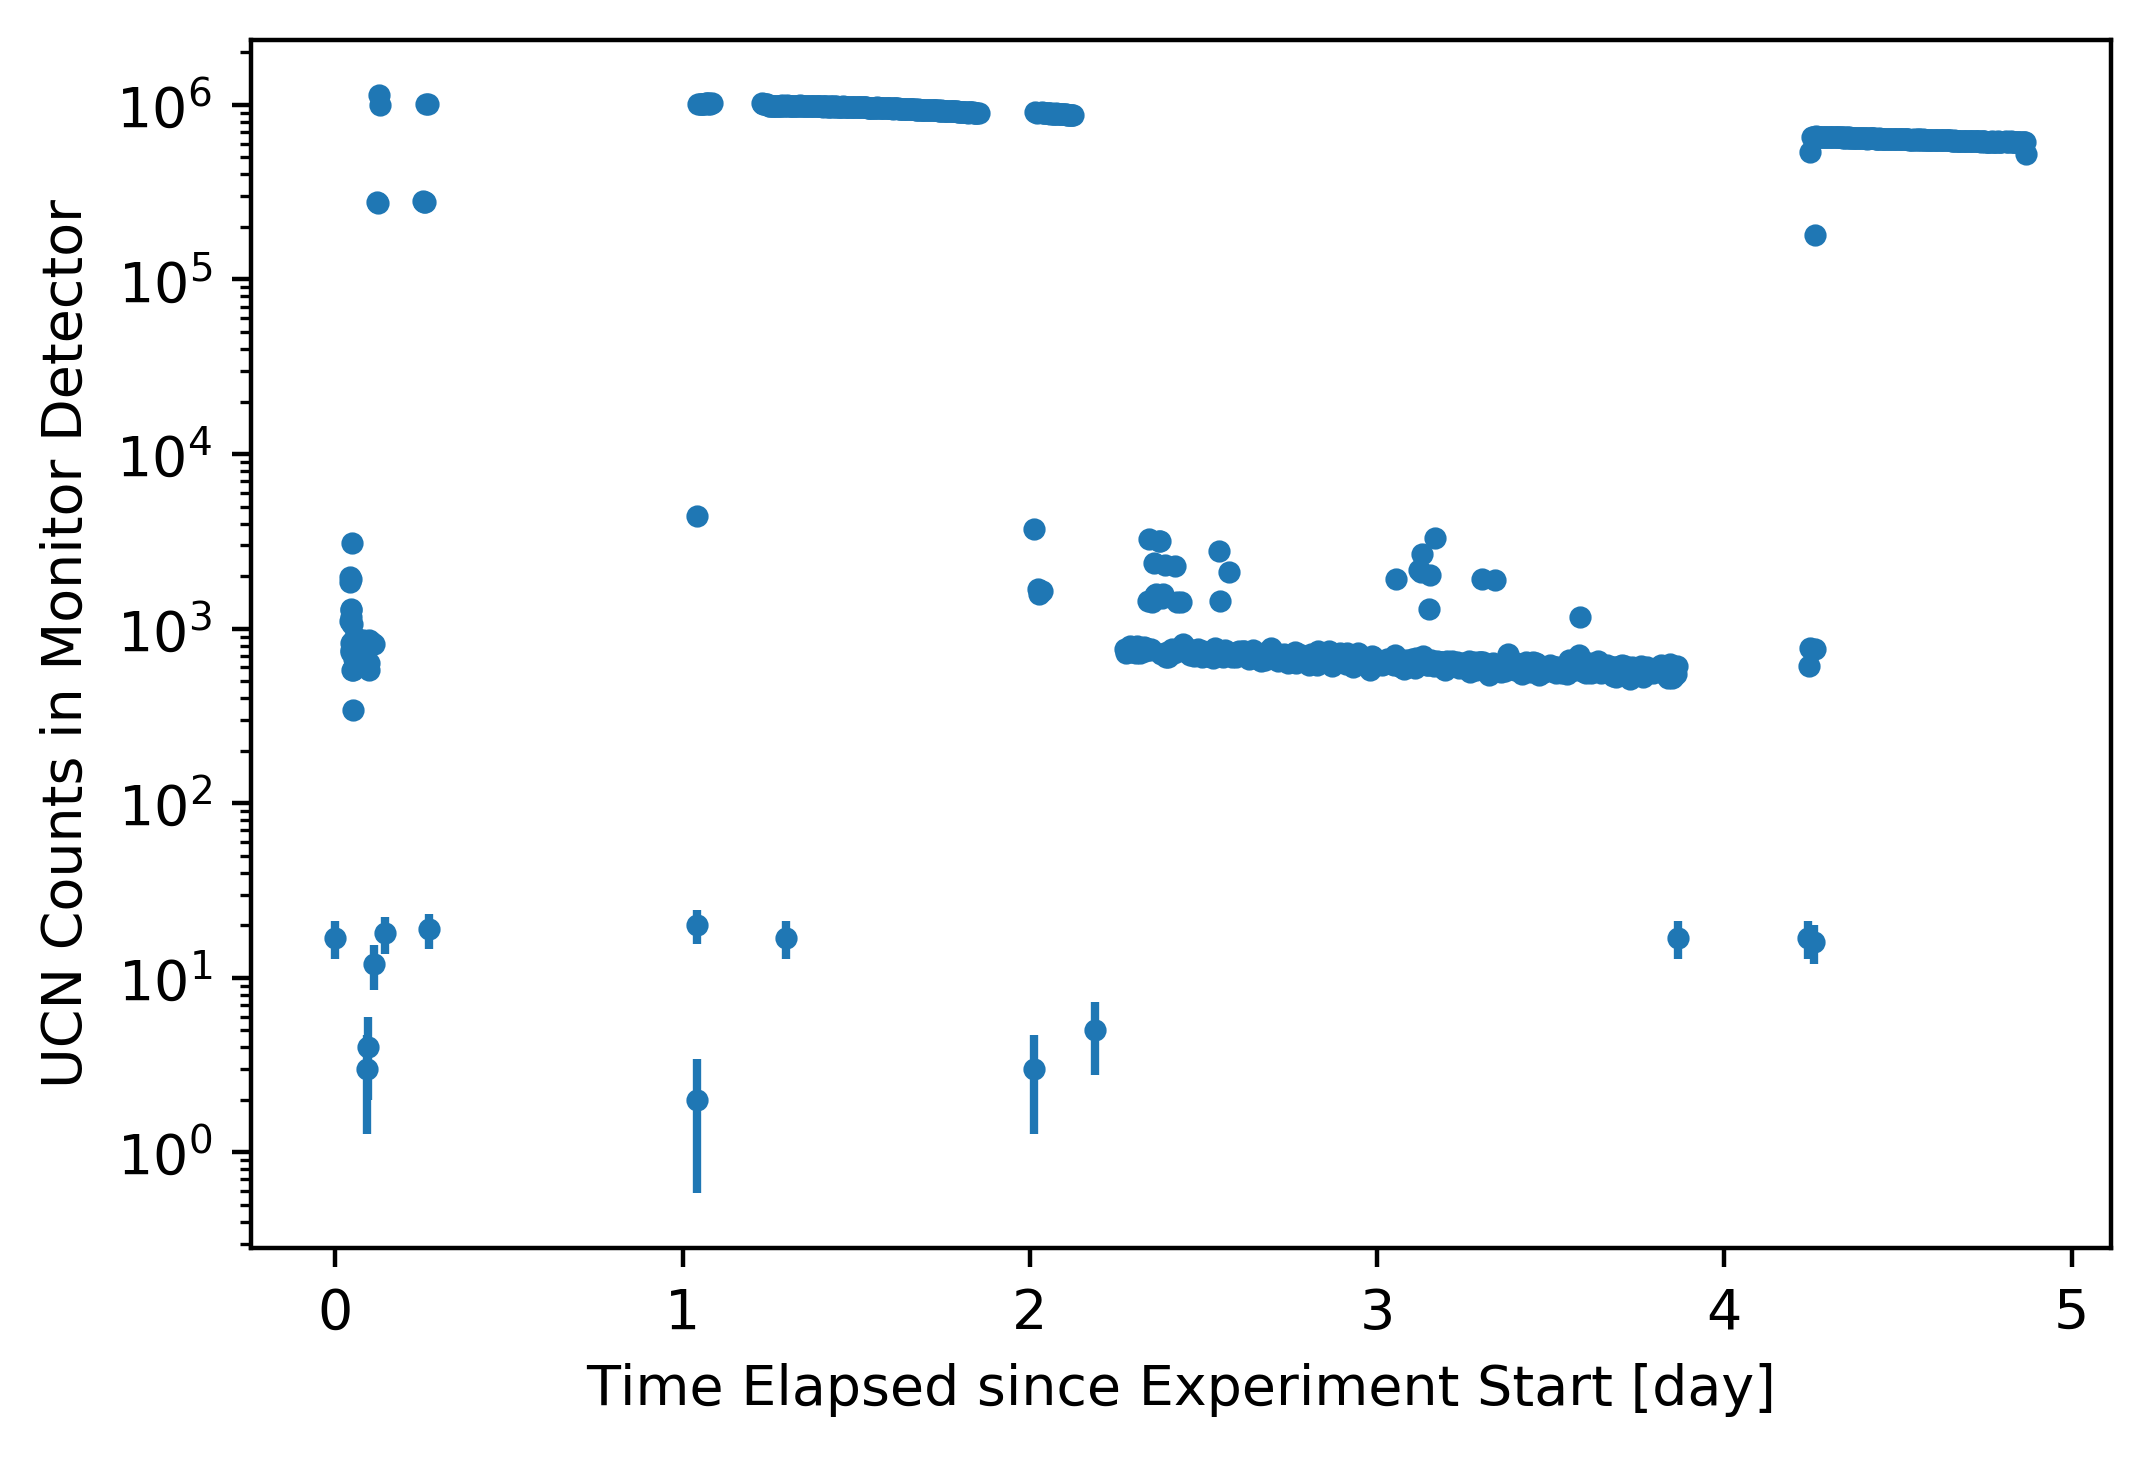

In [19]:
plt.errorbar(times_all_monitor/60/60/24, result_all_monitor[:,0], yerr = result_all_monitor[:,1], fmt = '.')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Time Elapsed since Experiment Start [day]')
plt.ylabel('UCN Counts in Monitor Detector');
plt.yscale('log')

I think that what we're seeing here is the monitor counts from runs that were thrown out have much higher counts. The main chunk of experimental run data occurred on Dec. 8-11, which would correspond to the region of stability between days 2 and 4. 
If we re-run this procedure on just the monitor_data files which are represented in the elog, then we should see a clearer and more reliable trend. Here is the full elog list of accepted runs:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
--- - 21                     | 8   |      n/a            | BAD                    |
 22 - 24                     | 8   |       20            | normalization          |
 25 - 31                     | 8   |      100            | normalization          |
 32 - 35*                    | 8   |        5            | normalization          |
      48                     | 8   |   direct            | JP SUS guide with NiP  |
      49                     | 8   |   direct            | BAD                    |
 50 - 60                     | 8   |      100            | JP SUS guide with NiP  |
 61 - 63                     | 8   |        5            | JP SUS guide with NiP  |
 64 - 66*                    | 8   |       20            | JP SUS guide with NiP  |
      76                     | 8   |   direct            | normalization          |
 77 - 79                     | 8   |        5            | normalization          |
 80 - 82                     | 8   |       20            | normalization          |
 83 - 88$^\dagger$           | 8   |      100            | normalization          |
      98                     | 8   |   direct            | JP Ti guide with NiP   |
 99 - 105                    | 8   |      100            | JP Ti guide with NiP   |
  1 - 90                     | 9   |      100            | JP Ti guide with NiP   |
 99 - 101                    | 9   |       20            | JP Ti guide with NiP   |
102 - 110                    | 9   |        5            | JP Ti guide with NiP   |
      120                    | 9   |   direct            | normalization          |
121 - 123                    | 9   |        5            | normalization          |
124 - 125                    | 9   |       20            | normalization          |
      127                    | 9   |       20            | normalization          |
128 - 135                    | 9   |      100            | normalization          |
      145                    | 9   |   direct            | SS disk                |
146 - 153                    | 9   |      100            | SS disk                |
154 - 156                    | 9   |       20            | SS disk                |
157 - 159                    | 9   |        5            | SS disk                |
      175                    | 9   |   direct            | normalization          |
176 - 183                    | 9   |      100            | normalization          |
184 - 186                    | 9   |       20            | normalization          |
187 - 189                    | 9   |        5            | normalization          |
      198                    | 9   |   direct            | UGD01                  |
      199                    | 9   |      100            | UGD01                  |
  1 - 107                    | 10  |      100            | UGD01                  |
108 - 110                    | 10  |       20            | UGD01                  |
111 - 113                    | 10  |        5            | UGD01                  |
      122                    | 10  |   direct            | normalization          |
123 - 130                    | 10  |      100            | normalization          |
131 - 133                    | 10  |       20            | normalization          |
134 - 136                    | 10  |        5            | normalization          |
      145                    | 10  |   direct            | UGD03                  |
146 - 155                    | 10  |      100            | UGD03                  |
156 - 158                    | 10  |       20            | UGD03                  |
159 - 161                    | 10  |        5            | UGD03                  |
      170                    | 10  |   direct            | normalization          |
171 - 179                    | 10  |      100            | normalization          |
180 - 182                    | 10  |       20            | normalization          |
183 - 185                    | 10  |        5            | normalization          |
193 - 194                    | 10  |   direct            | EP SUS guide with NiP  |
      195                    | 10  |      100            | EP SUS guide with NiP  |
196 - 198                    | 10  |        5            | EP SUS guide with NiP  |
199 - 201                    | 10  |       20            | EP SUS guide with NiP  |
202 - 241                    | 10  |      100            | EP SUS guide with NiP  |
      249                    | 10  |   direct            | normalization          |
250 - 252                    | 10  |        5            | normalization          |
253 - 255                    | 10  |       20            | normalization          |
256 - 265$^{**}$             | 10  |      100            | normalization          |
273 - 274$^{\dagger\dagger}$ | 10  |   direct            | bad?                   |
275 - 278                    | 10  |       20            | bad?                   |
  1 -  93                    | 11  |       20            | bad?                   |
  
We'll exclude all the runs deonted as bad for now.

In [ ]:
# Next approach, analyzing just that monitor data from runs that we've deemed valid from inspection of the elog:

# initializing some empty arrays to hold the run and day lists
run_list = []
day_list = []

import os
for filename in os.listdir('../data_monitor/normalization'):
    if (".tof" in filename):
        run_list.append(filename[8:12].lstrip('0'))
        day_list.append(filename[1:3].lstrip('0'))
        
time_bins, times, data, monitor_data = load_data(
    run_list,
    day_list,
    just_monitor_flag = True)

result = direct_normalized_source_fit(times, monitor_data)

In [ ]:
plt.errorbar(times, result[:,0], yerr = result[:,1], fmt = '.')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Time Elapsed since Experiment Start [day]')
plt.ylabel('UCN Counts in Monitor Detector');
plt.yscale('log')

This makes less sense. Why would there be such a drop off in monitor counts from the 8th to the 9th of December? Looking quickly at a couple of example runs...

In [ ]:
data = np.loadtxt("../data_main/12/8/T081217_0076.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.show()

plt.clf()
data = np.loadtxt("../data_monitor/12/T081217_0076.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.show()
counts_1 = np.sum(data[:,1])
print('Total UCN monitor counts: {}'.format(counts_1))

plt.clf()
data = np.loadtxt("../data_main/12/9/T091217_0198.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.show()

plt.clf()
data = np.loadtxt("../data_monitor/12/T091217_0198.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
counts_2 = np.sum(data[:,1])
print('Total UCN monitor counts: {}'.format(counts_2))

The first two plots are from a Dec. 8th direct shot run, counts in the main_detector and monitor_detector, respectively. The latter two plots are from a Dec. 9th direct shot run, same detector order. Clearly something disastrous has happened to the monitor detector counts. At this point, my inclination is to discard this section of data, and use the two stable high count, $\sim 10^6$, regions that surround it in time. There's no mention in the elog that might explain what has happened here. Let's look at the runs around when the change occurred.

In [ ]:
data = np.loadtxt("../data_monitor/12/T091217_0124.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 124')
plt.show()


data = np.loadtxt("../data_monitor/12/T091217_0125.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 125')
plt.show()

plt.clf()
data = np.loadtxt("../data_monitor/12/T091217_0126.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 126')
plt.show()

plt.clf()
data = np.loadtxt("../data_monitor/12/T091217_0127.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 127')
plt.show()

plt.clf()
data = np.loadtxt("../data_monitor/12/T091217_0128.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 128')
plt.show()


This transition occurred between runs 125 and 127. There's a key elog comment from that time:

>[Sat, Dec 09, 2017, 14:05:10 ]  cyclotron out... Cyclotron status webpage says 1 hour maintenance.<br/>
[Sat, Dec 09, 2017, 17:36:52 ]  restarted. run 126 is not relevant cause not stable.<br/>
tof.127 =51154 consistent with before.

We see the issue in run 126, but there's no direct mention of what could have caused this drastic change in monitor counts during the cyclotron maintenance. This is a serious open question (!!!).

Perhaps there was also some noticeable change in the main detector counts over the course of these runs?

In [ ]:
data = np.loadtxt("../data_main/12/9/T091217_0124.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 124')
plt.show()


data = np.loadtxt("../data_main/12/9/T091217_0125.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 125')
plt.show()

plt.clf()
data = np.loadtxt("../data_main/12/9/T091217_0126.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 126')
plt.show()

plt.clf()
data = np.loadtxt("../data_main/12/9/T091217_0127.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 127')
plt.show()

plt.clf()
data = np.loadtxt("../data_main/12/9/T091217_0128.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Run 128')
plt.show()

No, if any degradation occurred to the source that was of the same order as we see in the monitor counts, then these runs would look significantly different. The next step here is to try a few different methods of computing degradation using the disconnected sections of monitor data available. The three methods I'll compare will be:

1) Fitting a linear decay to just the section of high count monitor data occurring on the 8th to run 127 on the 9th <br/>
2) Fitting a linear decay to just the section of low count monitor data starting at run 127 on the 9th <br/>
3) Fitting a linear decay to just the high count monitor data that occurs at the end of the experiment, well after the elog referenced runs ends

Along the way there will be some pruning necessary of the monitor data, as evidenced by the various outlying data points on the plot we saw earlier that had all of the monitor data runs available. 

![title](../misc/areas_monitor_counts.png)

### Monitor Count Fit 1: Run T081217_004.tof to T091217_0125.tof

In [20]:
# initializing some empty arrays to hold the run and day lists
run_list = []
day_list = []

import os
for filename in os.listdir('../data_monitor/norm_monitor_1'):
    if (".tof" in filename):
        run_list.append(filename[8:12].lstrip('0'))
        day_list.append(filename[1:3].lstrip('0'))
        
time_bins, times_norm_monitor_1, data, monitor_data_1 = load_data(
    run_list,
    day_list,
    just_monitor_flag = True)

result_norm_monitor_1 = direct_normalized_source_fit(times_norm_monitor_1, monitor_data_1)

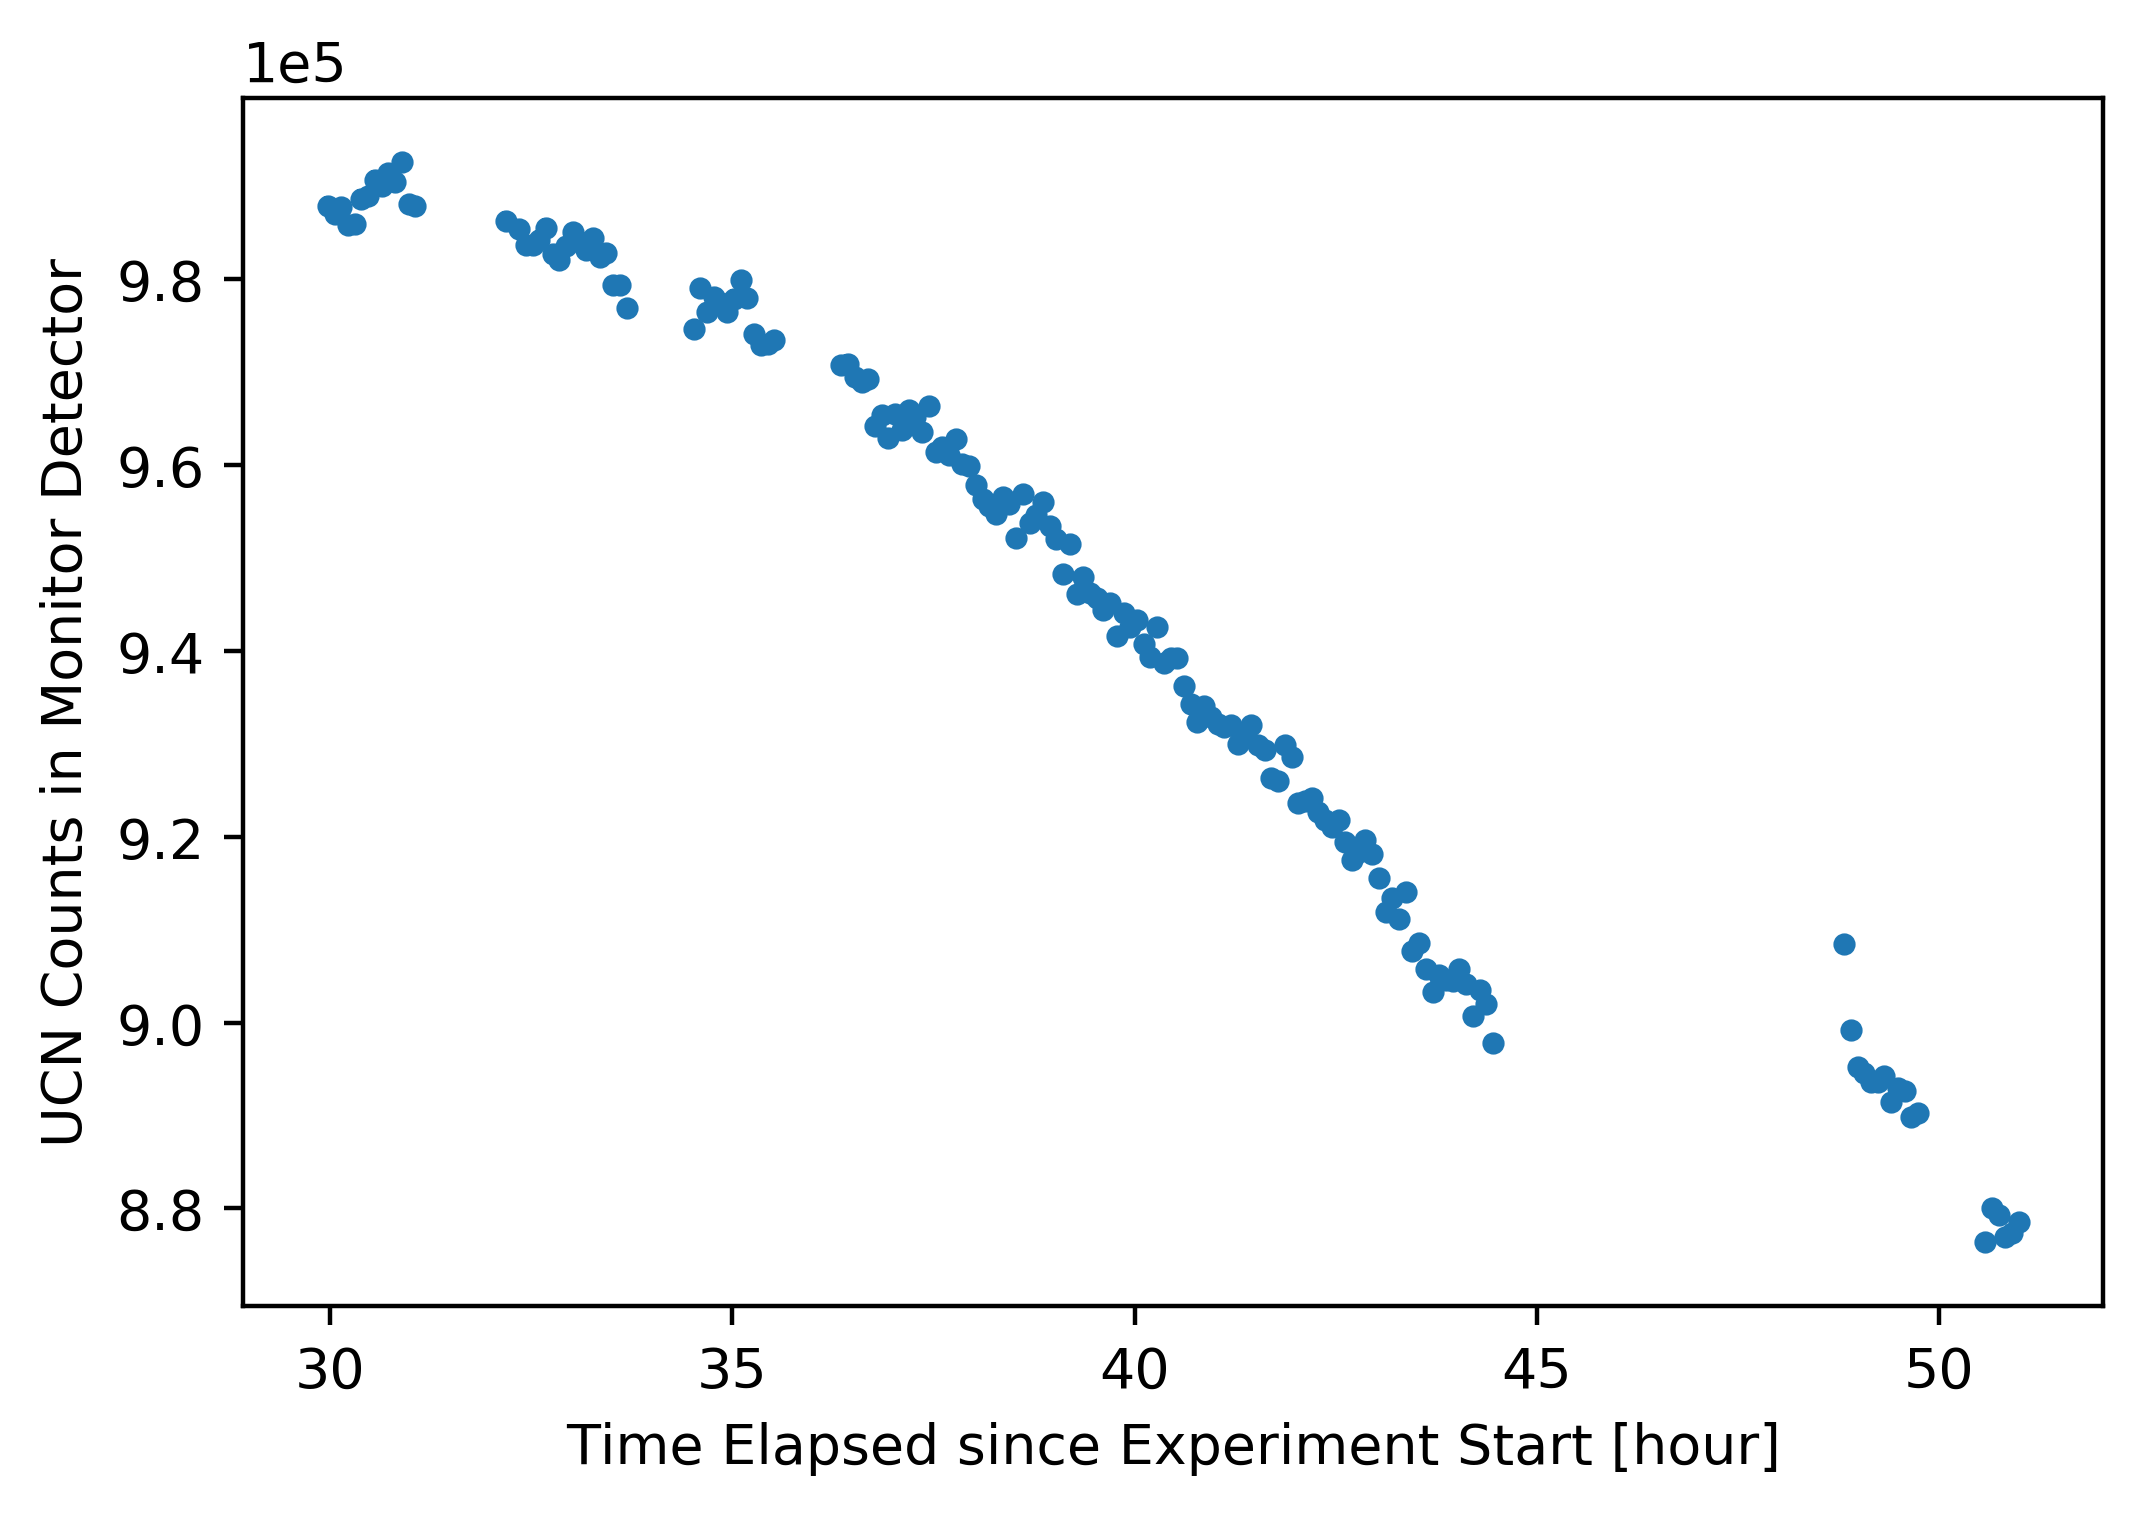

In [24]:
plt.errorbar(times_norm_monitor_1/60/60, result_norm_monitor_1[:,0], yerr = result_norm_monitor_1[:,1], fmt = '.')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Time Elapsed since Experiment Start [hour]')
plt.ylabel('UCN Counts in Monitor Detector');

The measurement gap observed near hour 45 can be explained by the elog:

>[Fri, Dec 08, 2017, 23:33:42 ]  leaving, getting stat over night. <br/>
tof.90 (091217) = 2571 <- last measurement before the beam stops, at around 7:30 AM. <br/>
[Sat, Dec 09, 2017, 08:00:43 ] storage 20 s when the beam restarts (seems not before 9:30 according to the PSI cyclotron webpage)... <br/>
[Sat, Dec 09, 2017, 11:49:43 ]  beam went back at around 11:30, but the first run with UCN produced is tof.99 (started at 11:50). <br/>
tof.99 = 27200

This is quite problematic. Why does the source performance appear to recover after the cyclotron beam returns? Maybe these are effects dependent on the target irradiation? The degradation is certainly not a simple linear behaviour here. 

### Monitor Count Fit 1: Run T081217_004.tof to End of Elog Referenced Runs

In [25]:
# initializing some empty arrays to hold the run and day lists
run_list = []
day_list = []

import os
for filename in os.listdir('../data_monitor/norm_monitor_2'):
    if (".tof" in filename):
        run_list.append(filename[8:12].lstrip('0'))
        day_list.append(filename[1:3].lstrip('0'))
        
time_bins, times_norm_monitor_2, data, monitor_data_2 = load_data(
    run_list,
    day_list,
    just_monitor_flag = True)

result_norm_monitor_2 = direct_normalized_source_fit(times_norm_monitor_2, monitor_data_2)

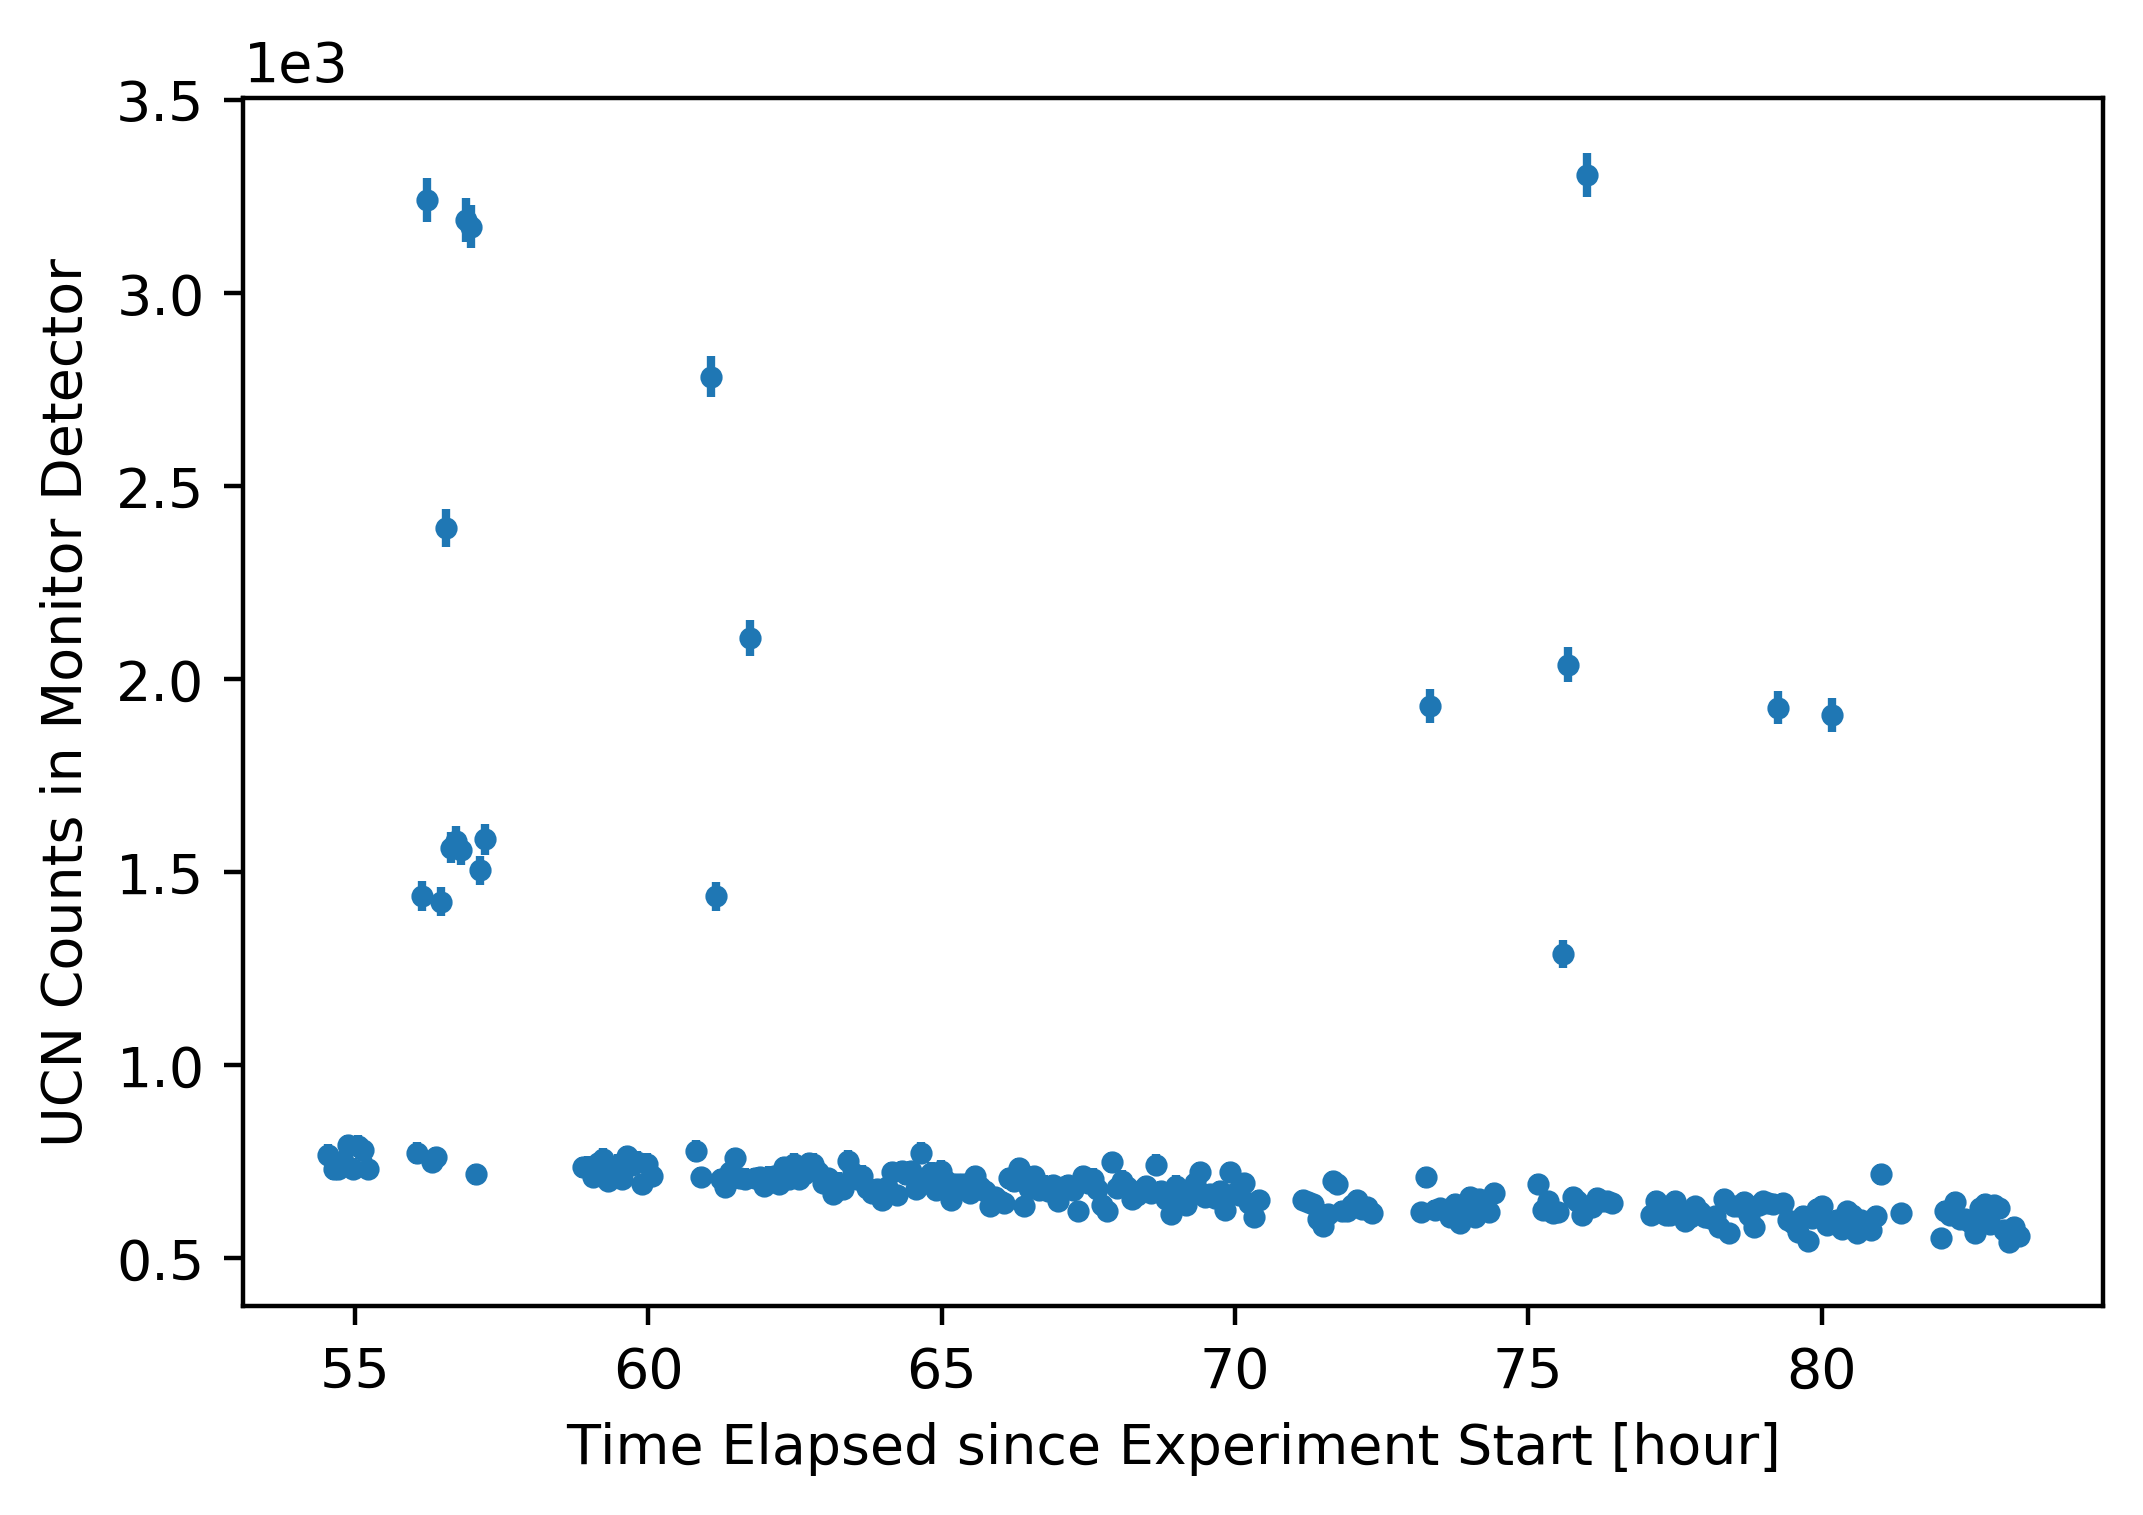

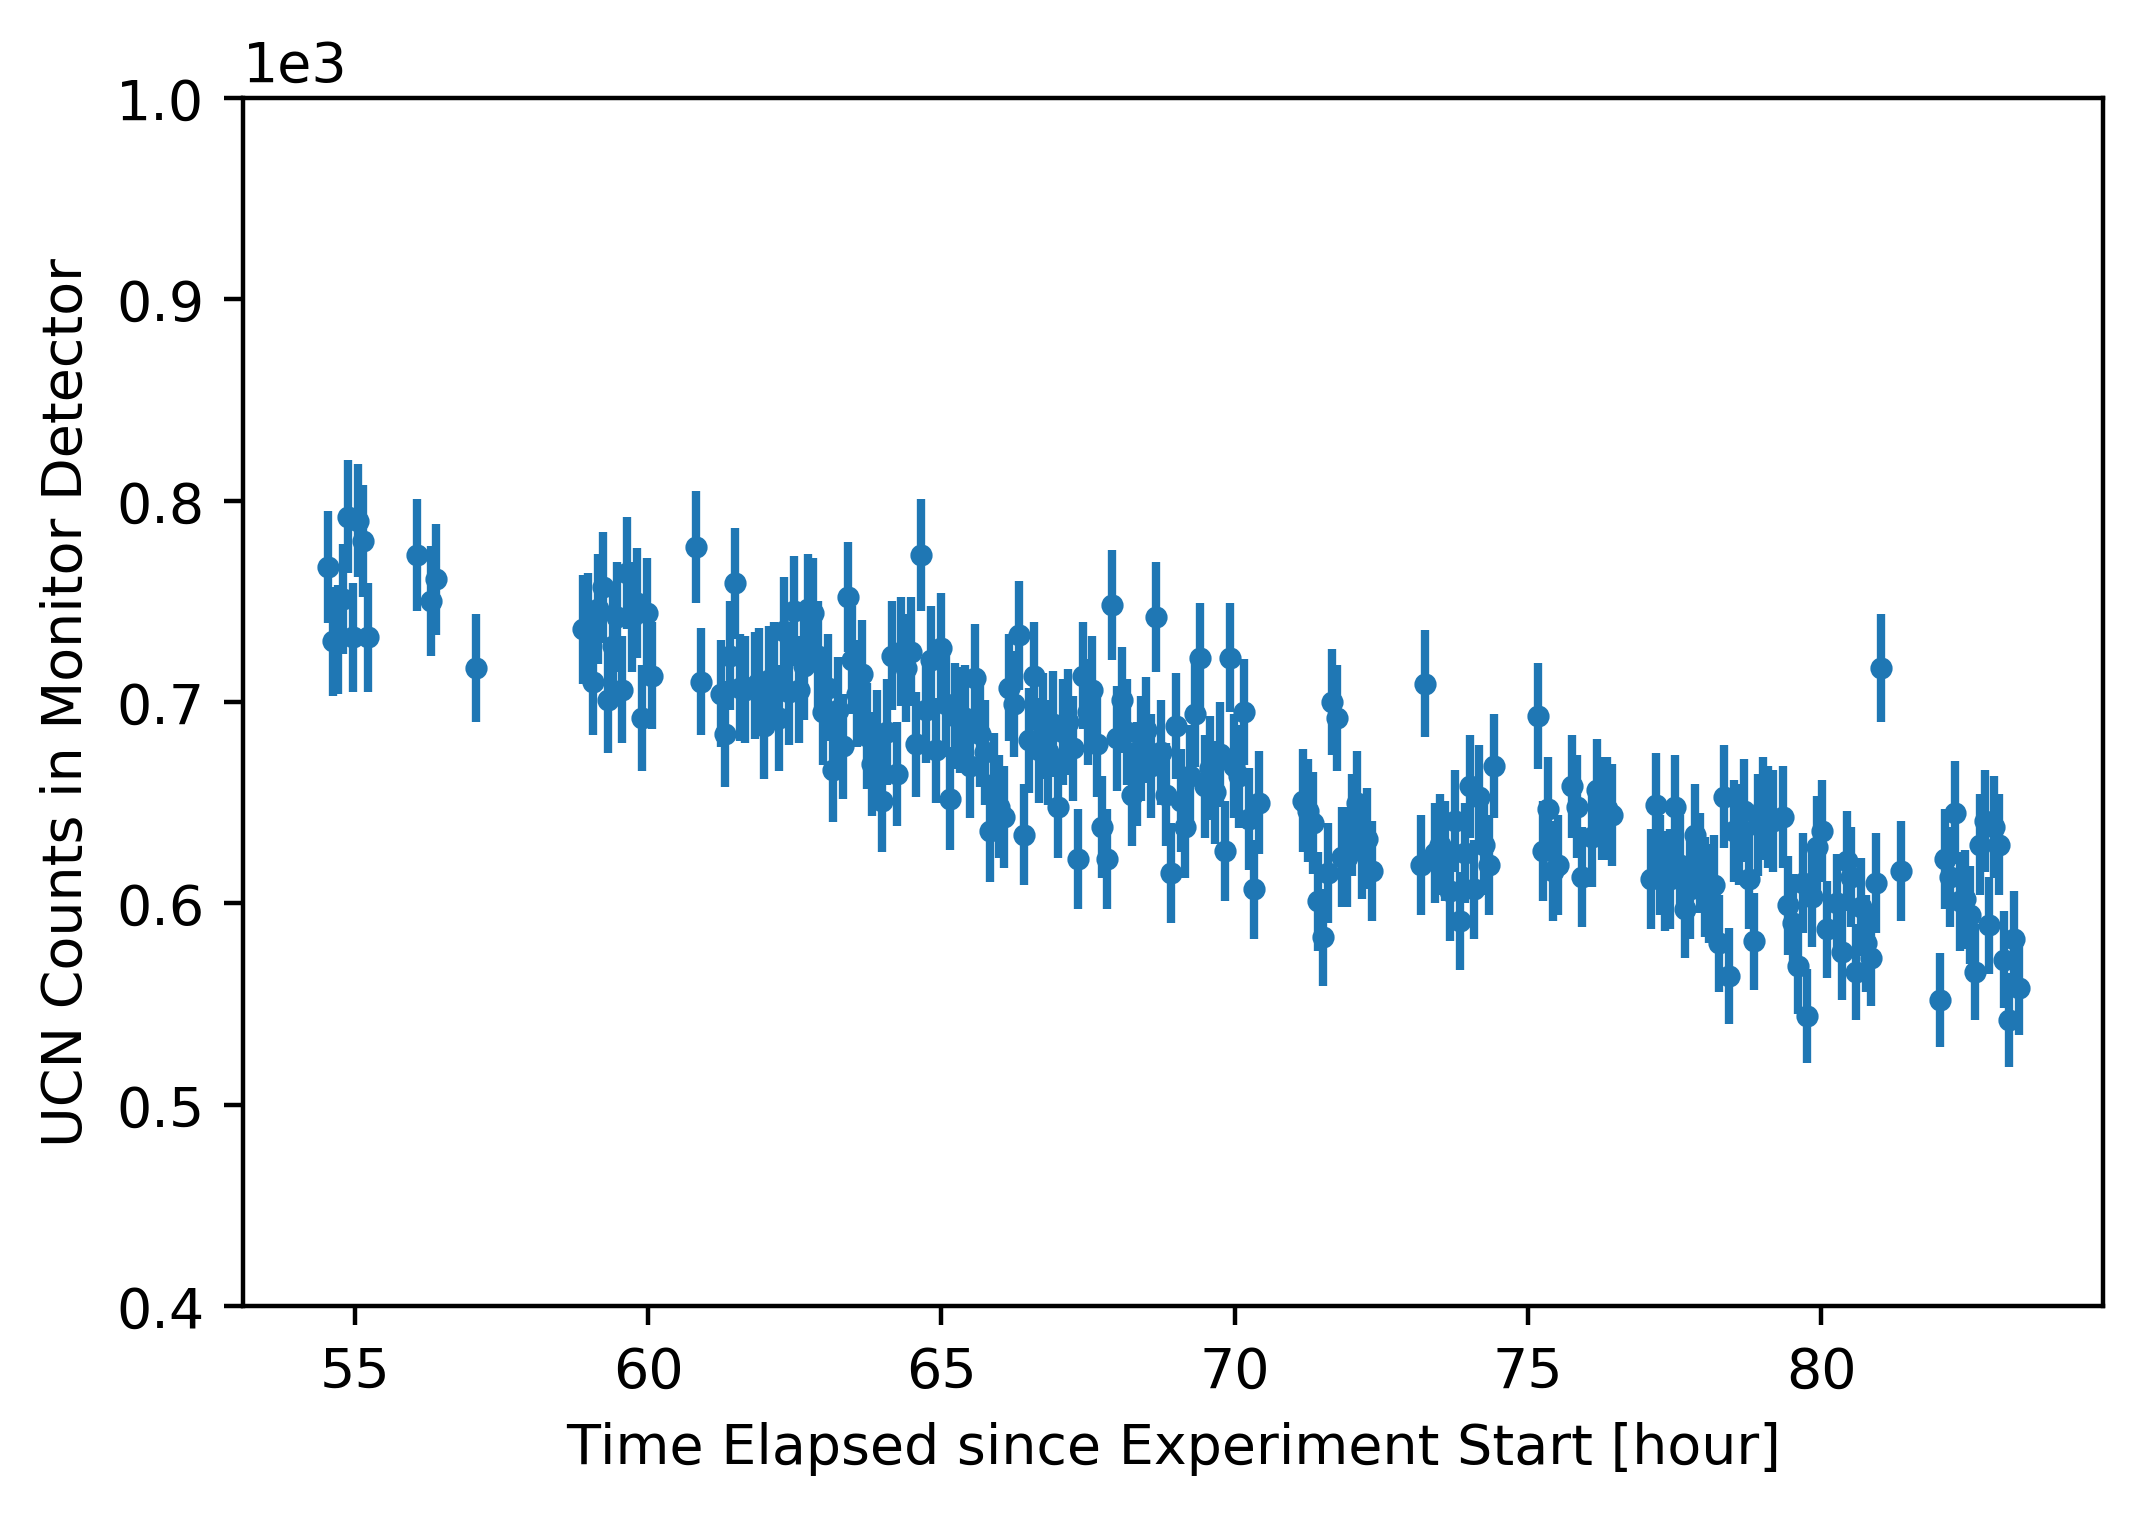

In [29]:
plt.errorbar(times_norm_monitor_2/60/60, result_norm_monitor_2[:,0], yerr = result_norm_monitor_2[:,1], fmt = '.')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Time Elapsed since Experiment Start [hour]')
plt.ylabel('UCN Counts in Monitor Detector');
plt.show()
plt.clf()
plt.errorbar(times_norm_monitor_2/60/60, result_norm_monitor_2[:,0], yerr = result_norm_monitor_2[:,1], fmt = '.')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Time Elapsed since Experiment Start [hour]')
plt.ylabel('UCN Counts in Monitor Detector');
plt.ylim([400,1000]);

Aside from these strange outlying data points, the curve appears to be linear and perhaps much more conducive to a fit.

(!!!) There are too many issues with the monitor data at present, this work needs to be reviewed with RP, perhaps sent to BL or EP, and then revisited. 

## Rough Workspace